In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d
import xarray as xr

In [2]:
path = os.getcwd().split('/')
machine_path = '/'+path[1]+'/'+path[2]

def find_nearest(array, value):
    '''Return the index in array nearest to a given value.
    
    Parameters
    ----------
    
    array: array_like
        1D array used to find the index
        
    value: float
        Value to be seached
    '''
    
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def read_params(fpath):
    '''
    Read Nx, Nz, Lx, Lz from param.txt
    '''
    with open(fpath+"param.txt","r") as f:
        line = f.readline()
        line = line.split() #split by space a string to a list of strings
        Nx = int(line[-1])
        
        line = f.readline()
        line = line.split()
        Nz = int(line[-1])

        line = f.readline()
        line = line.split()
        Lx = float(line[-1])

        line = f.readline()
        line = line.split()
        Lz = float(line[-1])

    return Nx, Nz, Lx, Lz

def read_data(prop, step, Nz, Nx, fpath):
    '''
    Read and reshape readed data according to parameters to return a (Nx, Nz) array
    '''
    
    #build filename
    filename = fpath + prop + "_" + str(step) + ".txt"

    data = np.loadtxt(filename, skiprows=2, unpack=True, comments="P")
    data = np.reshape(data, (Nz, Nx))
    
    return data

def calc_mean_temperaure_region(data, Nz, xx, begin, end):
    '''
    This funcition select a region in x direction in a 2D array and calculates the horizontal mean

    Parameters
    ----------

    data: `numpy.ndarray`

    Nz: int
        Number of points in Z direction

    xx: numpy.ndarray
        2D grid with x cordinates

    begin: float
        Start point

    end: float
        End point

    Returns
    -------
    arr: `numpy.ndarray`
        Array containing the horizontal mean of selected region
    '''

    x_region = (xx >= begin) & (xx <= end)
    Nx_aux = len(x_region[0][x_region[0]==True])
    data_sel = data[x_region].reshape(Nz, Nx_aux)
    data_sel_mean = np.mean(data_sel, axis=1)
    
    return data_sel_mean

In [3]:
label_size=18
plt.rc('xtick', labelsize=label_size)
plt.rc('ytick', labelsize=label_size)
#Setting the kind of tectonic scenario

scenario_kind = 'double_keel'

experiemnts = {
               'double_keel': 'Double Cratonic Keel',
               }

ncores=20

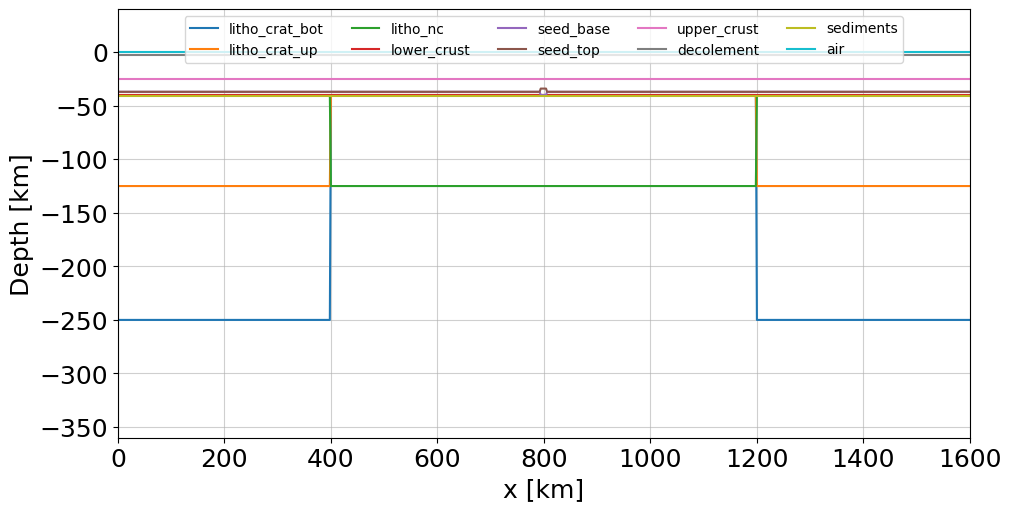

In [4]:
Lx = 1600 * 1.0e3
# total model vertical extent (m)
Lz = 400 * 1.0e3
# number of points in horizontal direction
Nx = 801
# number of points in vertical direction
Nz = 201

# thickness of sticky air layer (m)
thickness_sa = 40 * 1.0e3
#thickness of sediments (m)
thickness_sed = 1 *1.0e3
# thickness of decolement (m)
thickness_decolement = 2 *1.0e3
# thickness of upper crust (m)
thickness_upper_crust = 22 * 1.0e3
# thickness of lower crust (m)
thickness_lower_crust = 15 * 1.0e3
#Thickness of non cratonic lithosphere
thickness_mlit = 85 * 1.0e3
#thickness of cratonic lihosphere (upper)
thickness_mlit_crat_up = 85 * 1.0e3
#thickness of cratonic lithosphere (bottom)
thickness_mlit_crat_bot = 125 * 1.0e3

# total thickness of lithosphere (m)
thickness_litho = thickness_sed + thickness_decolement + thickness_upper_crust + thickness_lower_crust + thickness_mlit #125 km - reference is the non-cratonic lithosphere
thickness_crat_up = thickness_sed + thickness_decolement + thickness_upper_crust + thickness_lower_crust + thickness_mlit_crat_up
thickness_crat_bot = thickness_sed + thickness_decolement + thickness_upper_crust + thickness_lower_crust + thickness_mlit_crat_up + thickness_mlit_crat_bot


# seed depth bellow base of lower crust (m)
seed_depth = 3 * 1.0e3 #9 * 1.0e3 #original

x = np.linspace(0, Lx, Nx)
z = np.linspace(Lz, 0, Nz)
X, Z = np.meshgrid(x, z)

interfaces = {
        "litho_crat_bot": np.ones(Nx) * (thickness_sa + thickness_sed + thickness_decolement + thickness_upper_crust + thickness_lower_crust + thickness_mlit_crat_up + thickness_mlit_crat_bot), #lower portion - this interface starts from the base of cratonic region
        "litho_crat_up": np.ones(Nx) * (thickness_sa + thickness_sed + thickness_decolement + thickness_upper_crust + thickness_lower_crust + thickness_mlit_crat_up), #upper portion - this interface starts from the base of cratonic region
        "litho_nc": np.ones(Nx) * (thickness_sa + thickness_sed + thickness_decolement + thickness_upper_crust + thickness_lower_crust), #non cratonic lithosphere - this interface starts from the base of lower crust
        "lower_crust": np.ones(Nx) * (thickness_sa + thickness_sed + thickness_decolement + thickness_upper_crust + thickness_lower_crust),
        "seed_base": np.ones(Nx) * (thickness_sa + thickness_sed + thickness_decolement + thickness_upper_crust + thickness_lower_crust - seed_depth),
        "seed_top": np.ones(Nx) * (thickness_sa + thickness_sed + thickness_decolement + thickness_upper_crust + thickness_lower_crust - seed_depth),
        "upper_crust": np.ones(Nx) * (thickness_sa + thickness_sed + thickness_decolement + thickness_upper_crust),
        "decolement": np.ones(Nx) * (thickness_sa + thickness_sed + thickness_decolement),
        "sediments": np.ones(Nx) * (thickness_sa + thickness_sed + thickness_sa),
        "air": np.ones(Nx) * (thickness_sa),
        }

#Building non cratonic lithosphere
dx = Lx/(Nx-1)
L_nc = 800.0e3 #m
N_nc = int(L_nc//dx)

thickening = thickness_mlit #m
interfaces['litho_nc'][Nx//2 - N_nc//2 : Nx//2 + N_nc//2] = thickness_sa + thickness_sed + thickness_decolement + thickness_upper_crust + thickness_lower_crust + thickening

#Building lower craton
L_thinning = L_nc
N_thinning = N_nc

thinning = thickness_mlit_crat_up + thickness_mlit_crat_bot #reach the base of the lower crust
interfaces['litho_crat_bot'][Nx//2 - N_thinning//2 : Nx//2 + N_thinning//2] = thickness_sa + thickness_crat_bot - thinning

#Building upper craton
thinning = thickness_mlit_crat_up
interfaces['litho_crat_up'][Nx//2 - N_thinning//2 : Nx//2 + N_thinning//2] = thickness_sa + thickness_crat_up - thinning

#Build seed
# seed thickness (m)
thickness_seed = 6 * 1.0e3
# seed horizontal position (m)
# x_seed = 800 * 1.0e3
x_seed = Lx / 2.0
# x_seed = Lx / 2.0 + 200.0e3
# seed: number of points of horizontal extent
n_seed = 6

interfaces["seed_base"][int(Nx * x_seed // Lx - n_seed // 2) : int(Nx * x_seed // Lx + n_seed // 2)] = thickness_sa + thickness_sed + thickness_decolement + thickness_upper_crust + thickness_lower_crust - seed_depth + thickness_seed // 2

interfaces["seed_top"][int(Nx * x_seed // Lx - n_seed // 2) : int(Nx * x_seed // Lx + n_seed // 2)] = thickness_sa + thickness_sed + thickness_decolement + thickness_upper_crust + thickness_lower_crust - seed_depth - thickness_seed // 2

fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)

for label, layer in interfaces.items():
    # print(label, "(size): ", np.size(layer))
    ax.plot(x/1.0E3, (-layer + thickness_sa)/1.0E3, label=f"{label}")


ax.set_xlabel("x [km]", fontsize=label_size)
ax.set_ylabel("Depth [km]", fontsize=label_size)

ax.set_yticks(np.arange(-Lz / 1e3, 1 / 1e3, 50))
ax.set_xlim([0, Lx/1000])
ax.set_ylim([(-Lz + thickness_sa) / 1e3, 0 + thickness_sa / 1e3])

ax.legend(loc='upper center', ncol=5)
ax.grid("-k", alpha=0.6)

figname = "interfaces_teste"
fig.savefig(f"{figname}.png", dpi=200)

In [5]:
#Rheological and Thermal parameters
C_air = 1.0
C_sed = 1.0
C_dec = 1.0
C_upper_crust = 1.0
C_lower_crust = 10.0
C_seed = 0.1
C_mlit = 1.0
C_mlit_uc = 1.0
C_mlit_lc = 1.0
C_ast = 1.0

rho_air = 1.0
rho_sed = 2700.0
rho_dec = 2700.0
rho_upper_crust = 2700.0
rho_lower_crust = 2800.0
rho_seed = 2800.0
rho_mlit = 3354.0
rho_mlit_uc = 3354.0
rho_mlit_lc = 3354.0
rho_ast = 3378.0

H_air = 0.0
H_sed = 2.5e-6 / 2700.0
H_dec = 2.5e-6 / 2700.0
H_upper_crust = 2.5e-6 / 2700.0 #9.259E-10
H_lower_crust = 0.8e-6 / 2800.0 #2.85E-10
H_seed = 0.8e-6 / 2800.0
H_mlit = 9.0e-12
H_mlit_uc = 9.0e-12
H_mlit_lc = 9.0e-12
H_ast = 7.38e-12 #Turccote book #Default is 0.0

A_air = 1.0E-18
A_sed = 8.574e-28
A_dec = 8.574e-28
A_upper_crust = 8.574e-28
A_lower_crust = 8.574e-28
A_seed = 8.574e-28
A_mlit = 2.4168e-15
A_mlit_uc = 2.4168e-15
A_mlit_lc = 2.4168e-15
A_ast = 1.393e-14

n_air = 1.0
n_sed = 4.0
n_dec = 4.0
n_upper_crust = 4.0
n_lower_crust = 4.0
n_seed = 4.0
n_mlit = 3.5
n_mlit_uc = 3.5
n_mlit_lc = 3.5
n_ast = 3.0

Q_air = 0.0
Q_sed = 222.0e3
Q_dec = 222.0e3
Q_upper_crust = 222.0e3
Q_lower_crust = 222.0e3
Q_seed = 222.0e3
Q_mlit = 540.0e3
Q_mlit_uc = 540.0e3
Q_mlit_lc = 540.0e3
Q_ast = 429.0e3

V_air = 0.0
V_sed = 0.0
V_dec = 0.0
V_upper_crust = 0.0
V_lower_crust = 0.0
V_seed = 0.0
V_mlit = 25.0e-6
V_mlit_uc = 25.0e-6
V_mlit_lc = 25.0e-6
V_ast = 15.0e-6

with open("interfaces.txt", "w") as f:
    rheology_mlit = 'dry' #rheology of lithospheric mantle: dry olivine or wet olivine
    layer_properties = f"""
        C   {C_ast}   {C_mlit_lc}   {C_mlit_uc}   {C_mlit}   {C_lower_crust}   {C_seed}   {C_lower_crust}   {C_upper_crust}   {C_dec}   {C_sed}   {C_air}
        rho {rho_ast} {rho_mlit_lc} {rho_mlit_uc} {rho_mlit} {rho_lower_crust} {rho_seed} {rho_lower_crust} {rho_upper_crust} {rho_dec} {rho_sed} {rho_air}
        H   {H_ast}   {H_mlit_lc}   {H_mlit_uc}   {H_mlit}   {H_lower_crust}   {H_seed}   {H_lower_crust}   {H_upper_crust}   {H_dec}   {H_sed}   {H_air}
        A   {A_ast}   {A_mlit_lc}   {A_mlit_uc}   {A_mlit}   {A_lower_crust}   {A_seed}   {A_lower_crust}   {A_upper_crust}   {A_dec}   {A_sed}   {A_air}
        n   {n_ast}   {n_mlit_lc}   {n_mlit_uc}   {n_mlit}   {n_lower_crust}   {n_seed}   {n_lower_crust}   {n_upper_crust}   {n_dec}   {n_sed}   {n_air}
        Q   {Q_ast}   {Q_mlit_lc}   {Q_mlit_uc}   {Q_mlit}   {Q_lower_crust}   {Q_seed}   {Q_lower_crust}   {Q_upper_crust}   {Q_dec}   {Q_sed}   {Q_air}
        V   {V_ast}   {V_mlit_lc}   {V_mlit_uc}   {V_mlit}   {V_lower_crust}   {V_seed}   {V_lower_crust}   {V_upper_crust}   {V_dec}   {V_sed}   {V_air}
    """

    for line in layer_properties.split("\n"):
        line = line.strip()
        if len(line):
            f.write(" ".join(line.split()) + "\n")

    # layer interfaces
    data = -1 * np.array(tuple(interfaces.values())).T
    np.savetxt(f, data, fmt="%.1f")


In [6]:
high_kappa_in_asthenosphere = True
# high_kappa_in_asthenosphere = False #default

#Convergence criteria
denok                            = 1.0e-11
particles_per_element            = 100

#Surface constrains
sp_surface_tracking              = True
sp_surface_processes             = False

#time constrains 
time_max                         = 400.0e6
dt_max                           = 5.0e3 #default
step_print                       = 250

#External inputs: bc velocity, velocity field, precipitation and
#climate change
variable_bcv                     = True

velocity_from_ascii              = True
# velocity_from_ascii              = False


if(sp_surface_processes == True):
    precipitation_profile_from_ascii = True #False
    climate_change_from_ascii        = True #False
else:
    precipitation_profile_from_ascii = False
    climate_change_from_ascii        = False 

#step files
print_step_files                 = True

checkered = True
#velocity bc
top_normal_velocity                 = 'fixed'         # ok
top_tangential_velocity             = 'free '         # ok
bot_normal_velocity                 = 'fixed'         # ok
bot_tangential_velocity             = 'free '         # ok
left_normal_velocity                = 'fixed'         # ok
left_tangential_velocity            = 'free '         # ok
right_normal_velocity               = 'fixed'         # ok
right_tangential_velocity           = 'free'         # ok

# periodic_boundary = True
periodic_boundary = False

if(periodic_boundary == True):
    left_normal_velocity                = 'free'         # ok
    left_tangential_velocity            = 'free '         # ok
    right_normal_velocity               = 'free'         # ok
    right_tangential_velocity           = 'free'         # ok

#temperature bc
top_temperature                     = 'fixed'         # ok
bot_temperature                     = 'fixed'         # ok
# left_temperature                    = 'free'          # ok
left_temperature                    = 'fixed'          # ok
# right_temperature                   = 'free'          # ok
right_temperature                   = 'fixed'          # ok

##############################################################################
# Parameters file
##############################################################################
params = f"""
nx = {Nx}
nz = {Nz}
lx = {Lx}
lz = {Lz}
# Simulation options
multigrid                           = 1             # ok -> soon to be on the command line only
solver                              = direct        # default is direct [direct/iterative]
denok                               = {denok}       # default is 1.0E-4
particles_per_element               = {particles_per_element}          # default is 81
particles_perturb_factor            = 0.7           # default is 0.5 [values are between 0 and 1]
rtol                                = 1.0e-7        # the absolute size of the residual norm (relevant only for iterative methods), default is 1.0E-5
RK4                                 = Euler         # default is Euler [Euler/Runge-Kutta]
Xi_min                              = 1.0e-7       # default is 1.0E-14
random_initial_strain               = 0.2           # default is 0.0
pressure_const                      = -1.0          # default is -1.0 (not used) - useful only in horizontal 2D models
initial_dynamic_range               = True         # default is False [True/False]
periodic_boundary                   = False         # default is False [True/False]
high_kappa_in_asthenosphere         = {high_kappa_in_asthenosphere}         # default is False [True/False]
K_fluvial                           = 2.0e-7        # default is 2.0E-7
m_fluvial                           = 1.0           # default is 1.0
sea_level                           = 0.0           # default is 0.0
basal_heat                          = 0.0          # default is -1.0
# Surface processes
sp_surface_tracking                 = {sp_surface_tracking}         # default is False [True/False]
sp_surface_processes                = {sp_surface_processes}         # default is False [True/False]
sp_dt                               = 1.0e5        # default is 0.0
sp_d_c                              = 1.0          # default is 0.0
plot_sediment                       = False         # default is False [True/False]
a2l                                 = True          # default is True [True/False]
free_surface_stab                   = True          # default is True [True/False]
theta_FSSA                          = 0.5           # default is 0.5 (only relevant when free_surface_stab = True)
# Time constrains
step_max                            = 800000          # Maximum time-step of the simulation
time_max                            = {time_max}  #1.0e9     # Maximum time of the simulation [years]
dt_max                              = {dt_max}      # Maximum time between steps of the simulation [years]
step_print                          = {step_print} #500            # Make file every <step_print>
sub_division_time_step              = 0.5           # default is 1.0
initial_print_step                  = 0             # default is 0
initial_print_max_time              = 1.0e6         # default is 1.0E6 [years]
# Viscosity
viscosity_reference                 = 1.0e26        # Reference viscosity [Pa.s]
viscosity_max                       = 1.0e25        # Maximum viscosity [Pa.s]
viscosity_min                       = 1.0e18        # Minimum viscosity [Pa.s]
viscosity_per_element               = constant      # default is variable [constant/variable]
viscosity_mean_method               = arithmetic      # default is harmonic [harmonic/arithmetic]
viscosity_dependence                = pressure      # default is depth [pressure/depth]
# External ASCII inputs/outputs
interfaces_from_ascii               = True          # default is False [True/False]
n_interfaces                        = {len(interfaces.keys())}           # Number of interfaces int the interfaces.txt file
variable_bcv                        = {variable_bcv} #False         # default is False [True/False]
temperature_from_ascii              = True         # default is False [True/False]
velocity_from_ascii                 = {velocity_from_ascii} #False      # default is False [True/False]
binary_output                       = False         # default is False [True/False]
sticky_blanket_air                  = True         # default is False [True/False]
precipitation_profile_from_ascii    = {precipitation_profile_from_ascii}         # default is False [True/False]
climate_change_from_ascii           = {climate_change_from_ascii}         # default is False [True/False]
print_step_files                    = {print_step_files}          # default is True [True/False]
checkered                           = {checkered}         # Print one element in the print_step_files (default is False [True/False])
sp_mode                             = 5             # default is 1 [0/1/2]
geoq                                = on            # ok
geoq_fac                            = 100.0           # ok
# Physical parameters
temperature_difference              = 1500.         # ok
thermal_expansion_coefficient       = 3.28e-5       # ok
thermal_diffusivity_coefficient     = 1.0e-6 #0.75e-6       #default is 1.0e-6        # ok
gravity_acceleration                = 10.0          # ok
density_mantle                      = 3300.         # ok
external_heat                       = 0.0e-12       # ok
heat_capacity                       = 1250         # ok #default is 1250
non_linear_method                   = on            # ok
adiabatic_component                 = on            # ok
radiogenic_component                = on            # ok
# Velocity boundary conditions
top_normal_velocity                 = fixed         # ok
top_tangential_velocity             = free          # ok
bot_normal_velocity                 = fixed         # ok
bot_tangential_velocity             = free          # ok
left_normal_velocity                = {left_normal_velocity}         # ok
left_tangential_velocity            = {left_tangential_velocity}          # ok
right_normal_velocity               = {right_normal_velocity}         # ok
right_tangential_velocity           = {right_tangential_velocity}         # ok
surface_velocity                    = 0.0e-2        # ok
multi_velocity                      = False         # default is False [True/False]
# Temperature boundary conditions
top_temperature                     = {top_temperature}         # ok
bot_temperature                     = {bot_temperature}         # ok
left_temperature                    = {left_temperature}         # ok
right_temperature                   = {right_temperature}         # ok
rheology_model                      = 19             # ok
T_initial                           = 3             # ok
"""

# Create the parameter file
with open("param.txt", "w") as f:
    for line in params.split("\n"):
        line = line.strip()
        if len(line):
            f.write(" ".join(line.split()) + "\n")

# scenario = '/Doutorado/cenarios/mandyoc/stable/lit80km/stable_PT200_rheol19_c1250_C1_HprodAst/'
# scenario_name = scenario.split('/')[-2]
# print(scenario_name)

In [7]:
DeltaT = 0
# DeltaT = 200
# DeltaT = 290
# DeltaT = 350

# preset = True
preset = False

#Force cold cratonic keel
# keel_adjust = True
# keel_adjust = False

if(preset == False):
    T = 1300 * (z - thickness_sa) / (thickness_litho)  # Temperature
    T_cratonic = 1300 * (z - thickness_sa) / (thickness_crat_bot)
    
    # T = 1300 * (z - thickness_sa) / (130*1.0E3)  # Temperature of 1300 isotherm bellow the lithosphere

    ccapacity = 1250*1.0 #937.5=75% #J/kg/K? #DEFAULT
    
    TP = 1262 #mantle potential temperature
    # TP = 1350
    # TP = 1400
    # TP = 1450

    Ta = (TP / np.exp(-10 * 3.28e-5 * (z - thickness_sa) / ccapacity)) + DeltaT
    # Ta = 1262 / np.exp(-10 * 3.28e-5 * (z - thickness_sa) / ccapacity)steady s

    T[T < 0.0] = 0.0
    cond1 = Ta<T #VICTOR
    T[T > Ta] = Ta[T > Ta] #apply the temperature of asthenosphere Ta where temperature T is greater than Ta, 

    T_cratonic[T_cratonic < 0.0] = 0.0
    cond1_cratonic = Ta<T_cratonic #VICTOR
    T_cratonic[T_cratonic > Ta] = Ta[T_cratonic > Ta] #apply the temperature of asthenosphere Ta where temperature T is greater than Ta, 


    # kappa = 0.75*1.0e-6 #thermal diffusivity
    kappa = 1.0e-6 #thermal diffusivity

    H = np.zeros_like(T)

    cond = (z >= thickness_sa) & (z < thickness_sa + thickness_sed + thickness_decolement + thickness_upper_crust + thickness_lower_crust)  # upper crust
    H[cond] = H_upper_crust

    cond = (z >= thickness_sa + thickness_sed + thickness_decolement + thickness_upper_crust) & (
        z < thickness_sa + thickness_sed + thickness_decolement + thickness_upper_crust + thickness_lower_crust
    )  # lower crust
    H[cond] = H_lower_crust

    Taux = np.copy(T)
    Taux_cratonic = np.copy(T_cratonic)
    t = 0
    dt = 5000
    dt_sec = dt * 365 * 24 * 3600
    # cond = (z > thickness_sa + thickness_litho) | (T == 0)  # (T > 1300) | (T == 0) #OLD
    cond = cond1 | (T == 0)  # (T > 1300) | (T == 0) #VICTOR
    cond_cratonic = cond1_cratonic | (T_cratonic == 0)
    dz = Lz / (Nz - 1)

    
    while t < 500.0e6:
        T[1:-1] += (
            kappa * dt_sec * ((T[2:] + T[:-2] - 2 * T[1:-1]) / dz ** 2)
            + H[1:-1] * dt_sec / ccapacity
        )
        T[cond] = Taux[cond]

        T_cratonic[1:-1] += (
            kappa * dt_sec * ((T_cratonic[2:] + T_cratonic[:-2] - 2 * T_cratonic[1:-1]) / dz ** 2)
            + H[1:-1] * dt_sec / ccapacity
        )
        T_cratonic[cond] = Taux_cratonic[cond]

        t = t + dt
    
    T = np.ones_like(X) * T[:, None] #(Nz, Nx)
    T_cratonic = np.ones_like(X) * T_cratonic[:, None] #(Nz, Nx)
    
    xcenter = Lx/2
    xregion_cratonic = (X <= xcenter - L_nc/2) | (X >= xcenter + L_nc/2)
    xregion_non_cratonic = (X > xcenter - L_nc/2) & (X < xcenter + L_nc/2)
    T[xregion_cratonic] = T_cratonic[xregion_cratonic]
    # print('shape T: ', np.shape(T))

    # Save the initial temperature file
    np.savetxt("input_temperature_0.txt", np.reshape(T, (Nx * Nz)), header="T1\nT2\nT3\nT4")
    
else:
    print("Need to implement!")


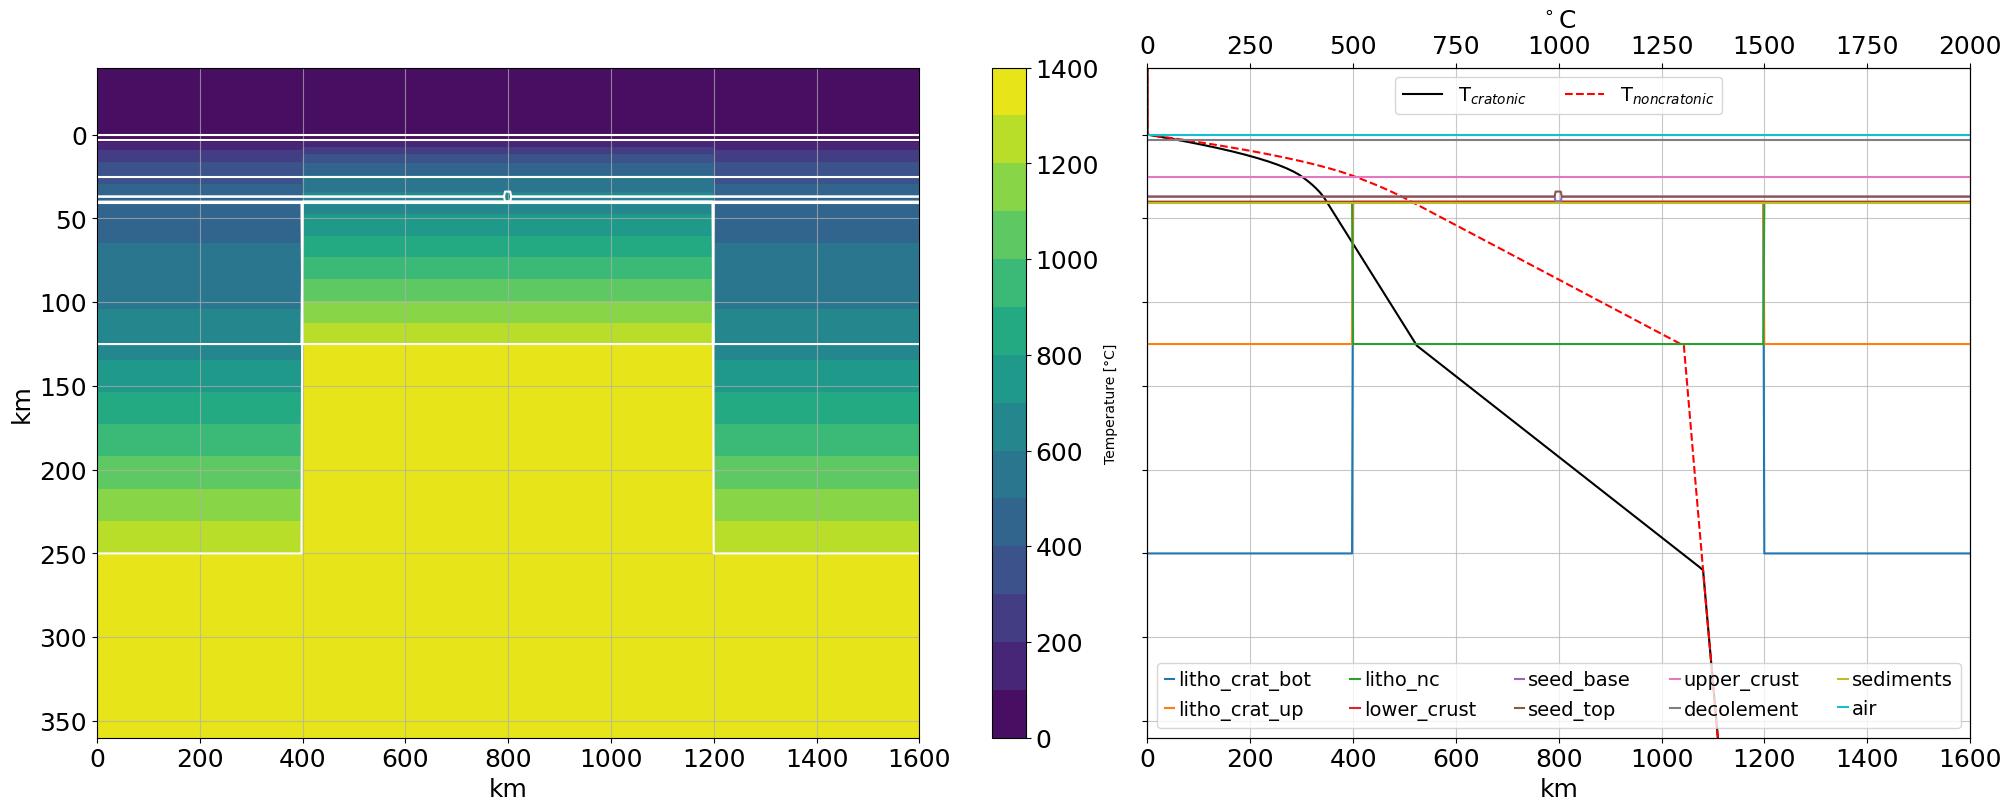

In [30]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(20, 8), sharey=True)

im = ax0.contourf(X / 1.0e3, (Z - thickness_sa) / 1.0e3, T,
                  levels=np.arange(0, np.max(T) + 100, 100))

idx_center = int((Nx-1)/2)
ax1.plot(T[:, 0], (z - thickness_sa) / 1.0e3, "-k", label=r'T$_{cratonic}$')
ax1.plot(T[:, idx_center], (z - thickness_sa) / 1.0e3, "--r", label=r'T$_{non cratonic}$')

ax_aux = ax1.twiny()

for label, layer in interfaces.items():
    # print(label, "(size): ", np.size(layer))
    # ax1.plot(x/1.0E3, (-layer + thickness_sa)/1.0E3, label=f"{label}")
    ax0.plot(x/1.0E3, (layer - thickness_sa)/1.0E3, color='xkcd:white')
    ax_aux.plot(x/1.0E3, (layer - thickness_sa)/1.0E3, label=label)

T_xlim = 2000 #oC

ax0.set_ylim((Lz - thickness_sa) / 1.0e3, -thickness_sa / 1000)
ax0.set_xlabel("km", fontsize=label_size)
ax0.set_ylabel("km", fontsize=label_size)


ax1.set_xlabel("$^\circ$C", fontsize=label_size)
cbar = fig.colorbar(im, orientation='vertical', ax=ax0)
cbar.set_label("Temperature [°C]")

ax1.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax1.xaxis.set_label_position('top')
ax1.set_ylim((Lz - thickness_sa) / 1.0e3, -thickness_sa / 1000)
ax1.set_xlim(0, T_xlim)
ax0.grid(':k', alpha=0.7)
ax1.grid(':k', alpha=0.7)

ax_aux.tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
ax_aux.xaxis.set_label_position('bottom')
ax_aux.set_xlabel('km', fontsize=label_size)
ax_aux.set_xlim(0, Lx/1000)
ax_aux.set_ylim((Lz - thickness_sa) / 1.0e3, -thickness_sa / 1000)

ax1.legend(loc='upper center', fontsize=14, ncol=2)
ax_aux.legend(loc='lower center', fontsize=14, ncol=5, handletextpad=0.2, handlelength=.5)

plt.savefig("initial_temperature_field.png")

In [9]:
##############################################################################
# Boundary condition - velocity
##############################################################################
if(velocity_from_ascii == True):
    fac_air = 10.0e3

    # 1 cm/year
    vL = 0.005 / (365 * 24 * 3600)  # m/s

    # 0.5 cm/year
    # vL = 0.0025 / (365 * 24 * 3600)  # m/s
    
    # 0.25 cm/year
    # vL = 0.00125 / (365 * 24 * 3600)  # m/s

    h_v_const = thickness_crat_bot + 20.0e3  #thickness with constant velocity 
    ha = Lz - thickness_sa - h_v_const  # difference

    vR = 2 * vL * (h_v_const + fac_air + ha) / ha  # this is to ensure integral equals zero

    VX = np.zeros_like(X)
    cond = (Z > h_v_const + thickness_sa) & (X == 0)
    VX[cond] = vR * (Z[cond] - h_v_const - thickness_sa) / ha

    cond = (Z > h_v_const + thickness_sa) & (X == Lx)
    VX[cond] = -vR * (Z[cond] - h_v_const - thickness_sa) / ha

    cond = X == Lx
    VX[cond] += +2 * vL

    cond = Z <= thickness_sa - fac_air
    VX[cond] = 0

    # print(np.sum(VX))

    v0 = VX[(X == 0)]
    vf = VX[(X == Lx)]
    sv0 = np.sum(v0[1:-1]) + (v0[0] + v0[-1]) / 2.0
    svf = np.sum(vf[1:-1]) + (vf[0] + vf[-1]) / 2.0
    # print(sv0, svf, svf - sv0)

    diff = (svf - sv0) * dz

    vv = -diff / Lx
    # print(vv, diff, svf, sv0, dz, Lx)

    VZ = np.zeros_like(X)

    cond = Z == 0
    VZ[cond] = vv
    #save bc to plot arraows in numerical setup
    vels_bc = np.array([v0, vf])
    vz0 = VZ[(z == 0)]

    np.savetxt("vel_bc.txt", vels_bc.T)
    np.savetxt("velz_bc.txt", vz0.T)
    # print(np.sum(v0))

    VVX = np.copy(np.reshape(VX, Nx * Nz))
    VVZ = np.copy(np.reshape(VZ, Nx * Nz))

    v = np.zeros((2, Nx * Nz))

    v[0, :] = VVX
    v[1, :] = VVZ

    v = np.reshape(v.T, (np.size(v)))

    # Create the initial velocity file
    np.savetxt("input_velocity_0.txt", v, header="v1\nv2\nv3\nv4")

    # Plot veolocity
    ##############################################################################
    plt.close()
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(9, 9), constrained_layout=True, sharey=True)

    ax0.plot(VX[:, 0]*1e10, (z - thickness_sa) / 1000, "k-", label="left side")
    ax1.plot(VZ[:, 0]*1e10, (z - thickness_sa) / 1000, "k-", label="left side")

    ax0.plot(VX[:, -1]*1e10, (z - thickness_sa) / 1000, "r-", label="right side")
    ax1.plot(VZ[:, -1]*1e10, (z - thickness_sa) / 1000, "r-", label="right side")

    ax0.legend(loc='upper left', fontsize=14)
    ax1.legend(loc='upper right', fontsize=14)

    ax0_xlim = ax0.get_xlim()
    ax1_xlim = ax1.get_xlim()

    ax0.set_yticks(np.arange(0, Lz / 1000, 40))
    ax1.set_yticks(np.arange(0, Lz / 1000, 40))

    ax0.set_ylim([Lz / 1000 - thickness_sa / 1000, -thickness_sa / 1000])
    ax1.set_ylim([Lz / 1000 - thickness_sa / 1000, -thickness_sa / 1000])

    ax0.set_xlim([-8, 8])
    ax1.set_xlim([-8, 8])
    ax0.set_xticks(np.arange(-8, 9, 4))
    ax1.set_xticks(np.arange(-8, 9, 4))
    ax0.grid(':k', alpha=0.7)
    ax1.grid(':k', alpha=0.7)

    ax0.set_xlabel("$10^{-10}$ (m/s)", fontsize=label_size)
    ax1.set_xlabel("$10^{-10}$ (m/s)", fontsize=label_size)
    ax0.set_ylabel("Depth (km)", fontsize=label_size)

    ax0.set_title("Horizontal component of velocity")

    ax1.set_title("Vertical component of velocity")

    plt.savefig("velocity.png")
    plt.close()


    if(variable_bcv == True):
        var_bcv = f""" 2
                    30.0 -1.0
                    60.0 1.0e-18
                    """

        # Create the parameter file
        with open("scale_bcv.txt", "w") as f:
            for line in var_bcv.split("\n"):
                line = line.strip()
                if len(line):
                    f.write(" ".join(line.split()) + "\n")

if(sp_surface_processes == True):
    if(climate_change_from_ascii == True):
        #When climate effects will start to act - scaling to 1
        climate = f'''
                2
                0 0.0
                120 0.02
            '''

        with open('climate.txt', 'w') as f:
            for line in climate.split('\n'):
                line = line.strip()
                if len(line):
                    f.write(' '.join(line.split()) + '\n')

    if(precipitation_profile_from_ascii ==True):
        #Creating precipitation profile

        prec = 0.0008*np.exp(-(x-Lx/2)**6/(Lx/(1))**6) #Lx km
        # prec = 0.0008*np.exp(-(x-Lx/2)**6/(Lx/8)**6) #original
        # prec = 0.0008*np.exp(-(x-Lx/2)**6/(Lx/(8*2))**6) #100 km
        # prec = 0.0008*np.exp(-(x-Lx/2)**6/(Lx/(8*4))**6) #50 km

        plt.figure(figsize=(12, 9), constrained_layout=True)
        plt.xlim([0, Lx/1.0E3])
        plt.ylim([0, np.max(prec)])
        plt.xlabel("km", fontsize=label_size)
        plt.ylabel("Precipitation", fontsize=label_size)
        plt.plot(x/1000,prec)
        plt.grid(':k', alpha=0.7)

        figname='precipitation_profile.png'
        plt.savefig(figname, dpi=300)

        np.savetxt("precipitation.txt", prec, fmt="%.8f")


In [10]:
print(f"Scenario kind: {experiemnts[scenario_kind]}")
print(f"N cores: {ncores}")
print('Domain parameters:')
print(f"\tLx: {Lx*1.0e-3} km")
print(f"\tLz: {Lz*1.0e-3} km")
print(f"\tNx: {Nx}")
print(f"\tNz: {Nz}")
print(f"Resolution dx x dz: {1.0e-3*Lx/(Nx-1)} x {1.0e-3*Lz/(Nz-1)} km2")
print('Layers thickness:')
print(f"\tair: {thickness_sa*1.0e-3} km")
print(f"\tsediments: {thickness_sed/1000} km")
print(f"\tdecolement: {thickness_decolement/1000} km")
print(f"\tupper crust: {thickness_upper_crust*1.0e-3} km")
print(f"\tlower crust: {thickness_lower_crust*1.0e-3} km")
print(f"\tnon cratonic mantle lithosphere: {thickness_litho} km")
print(f"\tupper cratonic mantle lithosphere: {thickness_mlit_crat_up/1000} km")
print(f"\tlower cratonic mantle lithosphere: {thickness_mlit_crat_bot/1000} km")
print(f"\tcrust: {(thickness_sed + thickness_decolement + thickness_upper_crust + thickness_lower_crust)/1000}")
print(f"\tnon cratonic lithosphere: {thickness_litho*1.0e-3} km")
print(f"\tcratonic lithosphere: {thickness_crat_bot*1.0e-3} km")
print('Important scale factors (C):')
print(f"\tair: {C_air}")
print(f"\tsediments: {C_seed}")
print(f"\tdecolement: {C_dec}")
print(f"\tupper crust: {C_upper_crust}")
print(f"\tlower crust: {C_lower_crust}")
print(f"\tweak seed: {C_seed}")
print(f"\tnon cratonic mantle lithosphere: {C_mlit}")
print(f"\tupper cratonic mantle lithosphere: {C_mlit_uc}")
print(f"\tlower cratonic mantle lithosphere: {C_mlit_lc}")
print(f"Preset of initial temperature field: {preset}")
print(f"Surface process: {sp_surface_processes}")
print(f"Velocity field: {velocity_from_ascii}")
print(f"Variable velocity field: {variable_bcv}")
print(f"Climate change: {climate_change_from_ascii}")
print(f"Periodic Boundary: {periodic_boundary}")
print('Initial temperature field setup:')
print(f"\tPreset of initial temperature field: {preset}")
print(f"\tIncrease in mantle basal temperature (Ta): {DeltaT} oC")
print(f"\tAssumed mantle Potential Temperature for diffusive model: {TP} oC")

#Save scenario infos
scenario_infos = ['SCENARIO INFOS:']
scenario_infos.append(' ')
scenario_infos.append('Name: ' + path[-1])
scenario_infos.append(f"Scenario kind: {experiemnts[scenario_kind]}")
scenario_infos.append(f"N cores: {ncores}")
scenario_infos.append(' ')
scenario_infos.append('Domain parameters:')
scenario_infos.append(f"\tLx: {Lx*1.0e-3} km")
scenario_infos.append(f"\tLz: {Lz*1.0e-3} km")
scenario_infos.append(f"\tNx: {Nx}")
scenario_infos.append(f"\tNz: {Nz}")
scenario_infos.append(f"Resolution dx x dz: {1.0e-3*Lx/(Nx-1)} x {1.0e-3*Lz/(Nz-1)} km2")
scenario_infos.append(' ')
scenario_infos.append('Layers thickness:')
scenario_infos.append(f"\tair: {thickness_sa*1.0e-3} km")
scenario_infos.append(f"\tsediments: {thickness_sed/1000} km")
scenario_infos.append(f"\tdecolement: {thickness_decolement/1000} km")
scenario_infos.append(f"\tupper crust: {thickness_upper_crust*1.0e-3} km")
scenario_infos.append(f"\tlower crust: {thickness_lower_crust*1.0e-3} km")
scenario_infos.append(f"\tnon cratonic mantle lithosphere:{ thickness_litho} km")
scenario_infos.append(f"\tupper cratonic mantle lithosphere: {thickness_mlit_crat_up/1000} km")
scenario_infos.append(f"\tlower cratonic mantle lithosphere: {thickness_mlit_crat_bot/1000} km")
scenario_infos.append(f"\tcrust: {(thickness_sed + thickness_decolement + thickness_upper_crust + thickness_lower_crust)/1000}")
scenario_infos.append(f"\tnon cratonic lithosphere: {thickness_litho*1.0e-3} km")
scenario_infos.append(f"\tcratonic lithosphere: {thickness_crat_bot*1.0e-3} km")
scenario_infos.append(' ')
scenario_infos.append(' ')
scenario_infos.append('Important scale factors (C):')
scenario_infos.append(f"\tair: {C_air}")
scenario_infos.append(f"\tsediments: {C_seed}")
scenario_infos.append(f"\tdecolement: {C_dec}")
scenario_infos.append(f"\tupper crust: {C_upper_crust}")
scenario_infos.append(f"\tlower crust: {C_lower_crust}")
scenario_infos.append(f"\tweak seed: {C_seed}")
scenario_infos.append(f"\tnon cratonic mantle lithosphere: {C_mlit}")
scenario_infos.append(f"\tupper cratonic mantle lithosphere: {C_mlit_uc}")
scenario_infos.append(f"\tlower cratonic mantle lithosphere: {C_mlit_lc}")
scenario_infos.append(' ')
scenario_infos.append(f"Preset of initial temperature field: {preset}")
scenario_infos.append(f"Surface process: {sp_surface_processes}")
scenario_infos.append(f"Velocity field: {velocity_from_ascii}")
scenario_infos.append(f"inital velocity: {vL*(365 * 24 * 3600)*2*100} cm/yr") 
scenario_infos.append(f"Variable velocity field: {variable_bcv}")
scenario_infos.append(f"Climate change: {climate_change_from_ascii}")
scenario_infos.append(f"Periodic Boundary: {periodic_boundary}")
scenario_infos.append('Initial temperature field setup:')
scenario_infos.append(f"\tPreset of initial temperature field: {preset}")
scenario_infos.append(f"\tIncrease in mantle basal temperature (Ta): {DeltaT} oC")
scenario_infos.append(f"\tAssumed mantle Potential Temperature for diffusive model: {TP} oC")

np.savetxt('infos_'+path[-1] + '.txt', scenario_infos, fmt="%s")

Scenario kind: Double Cratonic Keel
N cores: 20
Domain parameters:
	Lx: 1600.0 km
	Lz: 400.0 km
	Nx: 801
	Nz: 201
Resolution dx x dz: 2.0 x 2.0 km2
Layers thickness:
	air: 40.0 km
	sediments: 1.0 km
	decolement: 2.0 km
	upper crust: 22.0 km
	lower crust: 15.0 km
	non cratonic mantle lithosphere: 125000.0 km
	upper cratonic mantle lithosphere: 85.0 km
	lower cratonic mantle lithosphere: 125.0 km
	crust: 40.0
	non cratonic lithosphere: 125.0 km
	cratonic lithosphere: 250.0 km
Important scale factors (C):
	air: 1.0
	sediments: 0.1
	decolement: 1.0
	upper crust: 1.0
	lower crust: 10.0
	weak seed: 0.1
	non cratonic mantle lithosphere: 1.0
	upper cratonic mantle lithosphere: 1.0
	lower cratonic mantle lithosphere: 1.0
Preset of initial temperature field: False
Surface process: False
Velocity field: True
Variable velocity field: True
Climate change: False
Periodic Boundary: False
Initial temperature field setup:
	Preset of initial temperature field: False
	Increase in mantle basal temperature

1.0